# ECE 450 - Homework #9

### Package Imports


In [8]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal as sig
from control import margin, tf
import warnings
warnings.filterwarnings('ignore')


### Generic function to convolve any number of equations


In [11]:
def convolve_all(values):
    temp_conv = values[0]
    if len(values) > 1:
        for next_val in values[1:]:
            temp_conv = np.convolve(temp_conv, next_val)
    
    return temp_conv


### Generic function to get the transfer function of a Type $I$ Chevy-Chase Filter


In [58]:
def chevychase_type1(h_p, h_s, w_s, n=None):
    epsilon = np.sqrt(1 / (h_p ** 2) - 1)
    if n is None:
        n = int(np.ceil(np.cosh(1/epsilon * np.sqrt(1/(h_s * h_s) - 1)) / np.cosh(w_s)))
        
    alpha = 1 / epsilon + np.sqrt(1 + 1 / (epsilon ** 2))
    a = 0.5 * (alpha ** (1 / n) - alpha ** (-1 / n))
    b = 0.5 * (alpha ** (1 / n) + alpha ** (-1 / n))
    
    pole_list = []
    for k in range(1, n + 1):
        pole_list.append(complex(a * np.sin((np.pi * (2 * k - 1)) / (2 * n)), np.cos((np.pi * (2 * k - 1)) / (2 * n))))
# pole_list = [np.sin((np.pi * (2 * k - 1))/(2 * order)) + complex(0, np.cos((np.pi * (2 * k - 1))/(2 * order))) for k in range(1, order+1)]
    s_pole_list = [[1, pole] for pole in pole_list]
    
    den = convolve_all(s_pole_list)
    K = den[-1] if n % 2 == 1 else h_p * den[-1]

    return [K], den


### Generic function to get the transfer function of a Type $II$ Chevy-Chase Filter


In [59]:
def chevychase_type2(h_s, h_p, w_p, n=None):
    epsilon = np.sqrt(h_s ** 2 / (1 - h_s ** 2))
    if n is None:
        n = int(np.ceil(np.cosh(np.sqrt(1 / (epsilon ** 2 * (1 - h_p ** 2)))) / np.cosh(1 / w_p)))
        
    alpha = 1 / epsilon + np.sqrt(1 + 1 / (epsilon ** 2))
    a = 0.5 * (alpha ** (1 / n) - alpha ** (-1 / n))
    b = 0.5 * (alpha ** (1 / n) + alpha ** (-1 / n))
    
    pole_list = []
    for k in range(1, n + 1):
        pole_list.append(1 / complex(a * np.sin((np.pi * (2 * k - 1)) / (2 * n)), np.cos((np.pi * (2 * k - 1)) / (2 * n))))
# pole_list = [np.sin((np.pi * (2 * k - 1))/(2 * order)) + complex(0, np.cos((np.pi * (2 * k - 1))/(2 * order))) for k in range(1, order+1)]
    den = convolve_all([[1, pole] for pole in pole_list])
    
    zero_list = []
    for k in range(1, n * 2, 2):
        zero_list.append(1 / np.cos(k * np.pi / (2 * n)))
    num = convolve_all([[1, zero] for zero in zero_list])
    
    K = 1 / num[-1] * den[-1]

    return np.multiply(K, num), den


### Generic function to generate the $H(s)$ for a Buttersworth Filter of a given $n$ poles


In [2]:
def buttersworth_tf(order):
    pole_list = [np.sin((np.pi * (2 * k - 1))/(2 * order)) + complex(0, np.cos((np.pi * (2 * k - 1))/(2 * order))) for k in range(1, order+1)]
    s_pole_list = [[1, pole] for pole in pole_list]

    return convolve_all(s_pole_list)


### Generic function to get the minimum $n$ for a desired cutoff


In [3]:
def minimum_n(deviation, omega_p):
    return int(np.ceil(np.log10(1 / deviation ** 2 - 1) / (2 * np.log10(omega_p))))


### Generic function to convolve any number of equations


In [10]:
def convolve_all(values):
    temp_conv = values[0]
    if len(values) > 1:
        for next_val in values[1:]:
            temp_conv = np.convolve(temp_conv, next_val)
    
    return temp_conv


### Generic function to generate a lowpass, highpass, or bandpass Buttersworth filter


In [31]:
def lowpass_buttersworth(cutoff_freq=1, order=None, passband_deviation=None, passband_freq=None):
    # Move to cutoff frequency of 1 if necessary
    passband_freq = passband_freq if passband_freq is None else passband_freq / cutoff_freq
    
    order = order if order is not None else minimum_n(1 - passband_deviation, passband_freq) 
    
    # Generate the Buttersworth Transfer Function
    num = [1]
    den = buttersworth_tf(order)
    
    # Shift back to the given cutoff frequency
    num = np.multiply(cutoff_freq ** order, num)
    den = [term * (cutoff_freq ** t_order) for t_order, term in enumerate(den)]
    
    return num, den

def highpass_buttersworth(cutoff_freq=1, order=None, passband_deviation=None, passband_freq=None):
    # Move to cutoff frequency of 1 if necessary
    passband_freq = passband_freq if passband_freq is None else cutoff_freq / passband_freq
    
    order = order if order is not None else minimum_n(passband_deviation, passband_freq) 
    
    # Generate the Buttersworth Transfer Function
    num = np.zeros(order + 1)   # Make the s^order term 1 to move to a highpass filter
    num[0] = 1
    den = buttersworth_tf(order)
    
    # Shift back to the given cutoff frequency
    den = [term * (cutoff_freq ** t_order) for t_order, term in enumerate(den)]
    
    return num, den

def bandpass_buttersworth(center_freq=1, bandwidth=1, order=2):
    assert order % 2 == 0, "The order of the bandpass filter must be even."
    
    num = [1]
    den = buttersworth_tf(int(order / 2))
    
    # Shift back to the given bandwidth frequency
    num = np.multiply(bandwidth ** int(order / 2), num)
    den = [term * (bandwidth ** t_order) for t_order, term in enumerate(den)]
    
    # Transform up to the center frequency
    temp_den = np.zeros(len(den) + int(order / 2) + 1)
    for place, den_constant in enumerate(den):
        # The order of the applied (s^2 + val^2)
        ord2 = len(den) - place - 1
        
        # List of the applied shift for convolving
        stuff = [[1, 0, center_freq ** 2]] * ord2 if ord2 != 0 else [[1]]
        prod = np.multiply(den_constant, convolve_all(stuff))
        for _ in range(place): # Apply the multiplication of s^(n/2)
            prod = np.append(prod, 0)
            
        # Cumulatively calculate the new denominator
        temp_den = np.add(temp_den, np.pad(prod, (len(temp_den) - len(prod), 0), 'constant'))
        
    # Multiply the numerator by s^(n/2)
    num = np.pad(num, (0, int(order / 2)), 'constant')
        
    return num, temp_den


### Generic function to solve a set of state matrices


In [6]:
def state_solver(A_matrix, B_matrix, force_function, initial_conditions,
                 time_range=[0, 10], dt=0.01):
    time_values = np.arange(time_range[0], time_range[1], dt)
    x_vals = np.array(initial_conditions)
    state_variables = [[] for _ in range(len(initial_conditions))]
    
    # Loop through each instance in time, calculate the state variable at that time
    for time in time_values:
        if isinstance(force_function(time), np.ndarray):
            x_vals = x_vals + dt * (A_matrix @ x_vals) + dt * (B_matrix @ force_function(time))
        else:
            x_vals = x_vals + (dt * (A_matrix @ x_vals)) + dt * (B_matrix * force_function(time))
        for index, _ in enumerate(state_variables):
            state_variables[index].append(x_vals[index][0])
            
    return state_variables, time_values


### Generic function to plot the responses of a system


In [18]:
# Color list for multiple lines on each subplot
colors = ["red", "blue", "green", "gray", "purple", "orange"]
step_size = 0.005

# Generic Function to create a plot
def create_plot(x, y, xLabel=["X-Values"], yLabel=["Y-Values"],
                title=[("Plot", )], num_rows=1, size=(18, 14), logx=False):
    plt.figure(figsize=size, dpi=300)
    for c, (x_vals, y_vals, x_labels, y_labels, titles) in enumerate(zip(x, y, xLabel, yLabel, title)):
        for c2, (y_v, t) in enumerate(zip(y_vals, titles)):
            plt.subplot(num_rows, 1, c + 1)
            # Add a plot to the subplot, use transparency so they can both be seen
            plt.plot(x_vals, y_v, label=t, color=colors[c2], alpha=0.70)
            plt.ylabel(y_labels)
            plt.xlabel(x_labels)
            plt.grid(True)
            plt.legend(loc='lower right')
            if logx:
                plt.xscale("log")
    
    plt.show()


### Generic function to generate the magnitude and phase of $H(j\omega)$ values


In [19]:
def magnitude_phase_response(num, den, omega_range, omega_step=10, gain_num=None, gain_den=None):
    if isinstance(gain_num, (np.ndarray, list)) and isinstance(gain_den, (np.ndarray, list)):
        num = convolve_all([num, gain_num])
        den = convolve_all([den, gain_den])
        
    system = sig.lti(num, den)
    w, h_mag, h_phase = sig.bode(system, np.arange(omega_range[0], omega_range[1], omega_step))
    _, phase_margin, _, crossover_w = margin(h_mag, h_phase, w)
    
    return w, h_mag, h_phase, phase_margin, crossover_w


## Problem 8.3.3


Num:  [0.86505062] 
Den:  [1.         1.31173466 0.93016195]


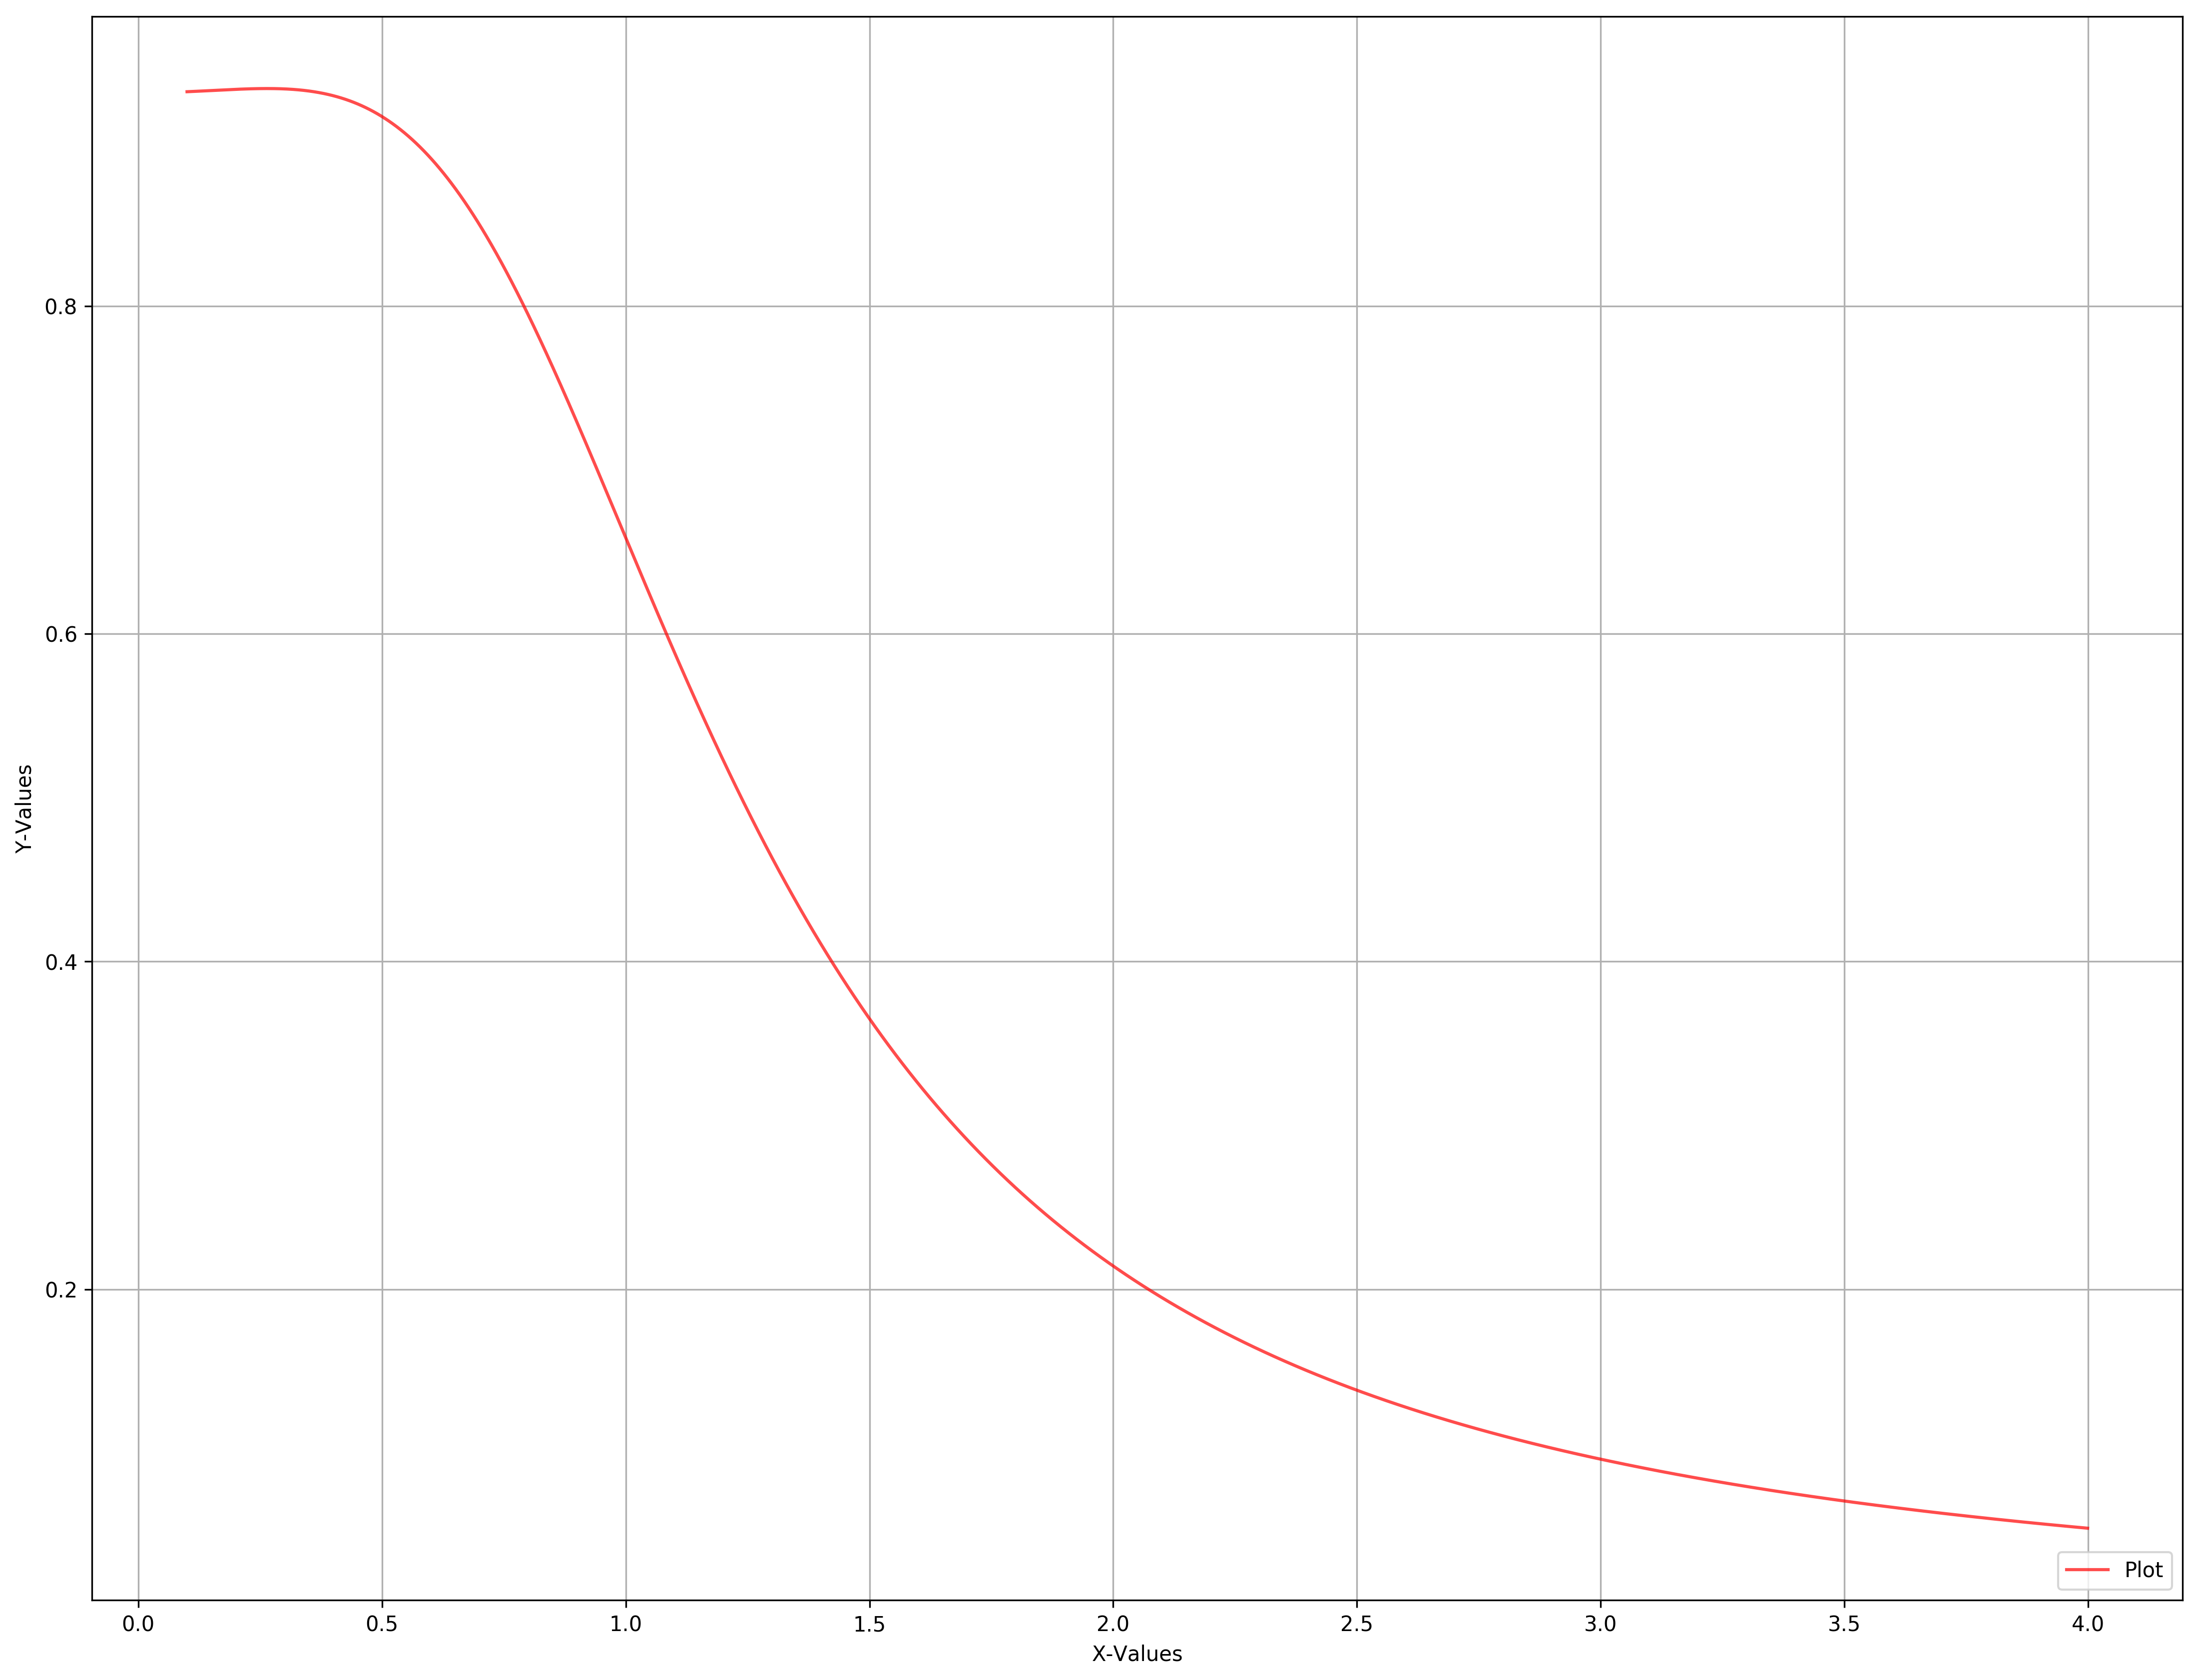

In [54]:
# def chevychase_type1_poles(h_p, h_s, w_s, n=None):
num, den = chevychase_type1(0.93, 0.1, 1, 2)
print ("Num: ", np.real(num), "\nDen: ", np.real(den))
w, h_mag, _, _, _ = magnitude_phase_response(num, den, [0.1, 4], 0.001)
create_plot([w], [(10 ** (0.05 * h_mag), )])

The minimum order Chebyshev filter that meets these design specifications is a 1st order. Who's $H(s)$ is 

$$H(s)=\frac{0.865}{s^2+1.312s+0.9302}$$

## Problem 8.3.5

Given: $\omega _p = 10^3$ and $\omega _s = 200$, $H_p = 10^{0.05 \cdot -0.5}$, and $H_s = 10^{0.05\cdot -20}$.

Need $\omega _s = 1$, therefore:

$$\omega _s = \frac{200}{200} \rightarrow \omega _s^0 = 1$$

$$\omega _p = \frac{10^3}{200}=5 \rightarrow \omega _p^0 = \frac{1}{5} = 0.2$$

$$\epsilon = \sqrt{\frac{H_s^2}{1-H_s^2}}=\sqrt{\frac{0.1^2}{1-0.1^2}} \approx 0.1005$$

$$n=cosh^{-1}(\sqrt{\frac{1}{\epsilon ^2(1-H_p^2)}})(\frac{1}{cosh^{-1}(\frac{1}{\omega _p})})\approx 2$$

$$\alpha=19.951, a=2.124, b=2.345$$

$$s_{1,2}=a\cdot cos(180\pm 45)+jb\cdot sin(180\pm 45)$$

$$s_1=-1.5-j1.66, s_2=-1.5+j1.66$$

Resulting in the poles:

$$q_{1,2}=\frac{1}{s_{1,2}}=-.3\pm j.33$$

And the zeros are:

$$w_{k_1}=sec(\frac{\pi}{4})=\sqrt{2}, w_{k_2}=sec(\frac{3\pi}{4})=-\sqrt{2}$$

Therefore, the Chevy-chase II low-pass filter with $\omega _s=1$ is:

$$H_0(s)=K\cdot \frac{(s-\sqrt{2})\cdot(s+\sqrt{2})}{(s-(0.3-j.33))\cdot (s-(0.3+j.33))}$$

$$H_0(s)=K\cdot \frac{s^2-2}{s^2-0.6s+0.1989}$$

Find K:

$$K=\frac{1}{H(0)}=\frac{1}{\frac{-2}{0.1989}}\approx -0.0995$$

Now switch to a high-pass filter:

$$H(s)=-0.0995\cdot \frac{-2s^2+1}{0.1989s^2-0.6s+1}$$

Scale up to $\omega _s = 200$ and $\omega _p = 10^3$:



[ 1.99e+00 -0.00e+00 -3.98e+04] [0.1989, -120.0, 40000]


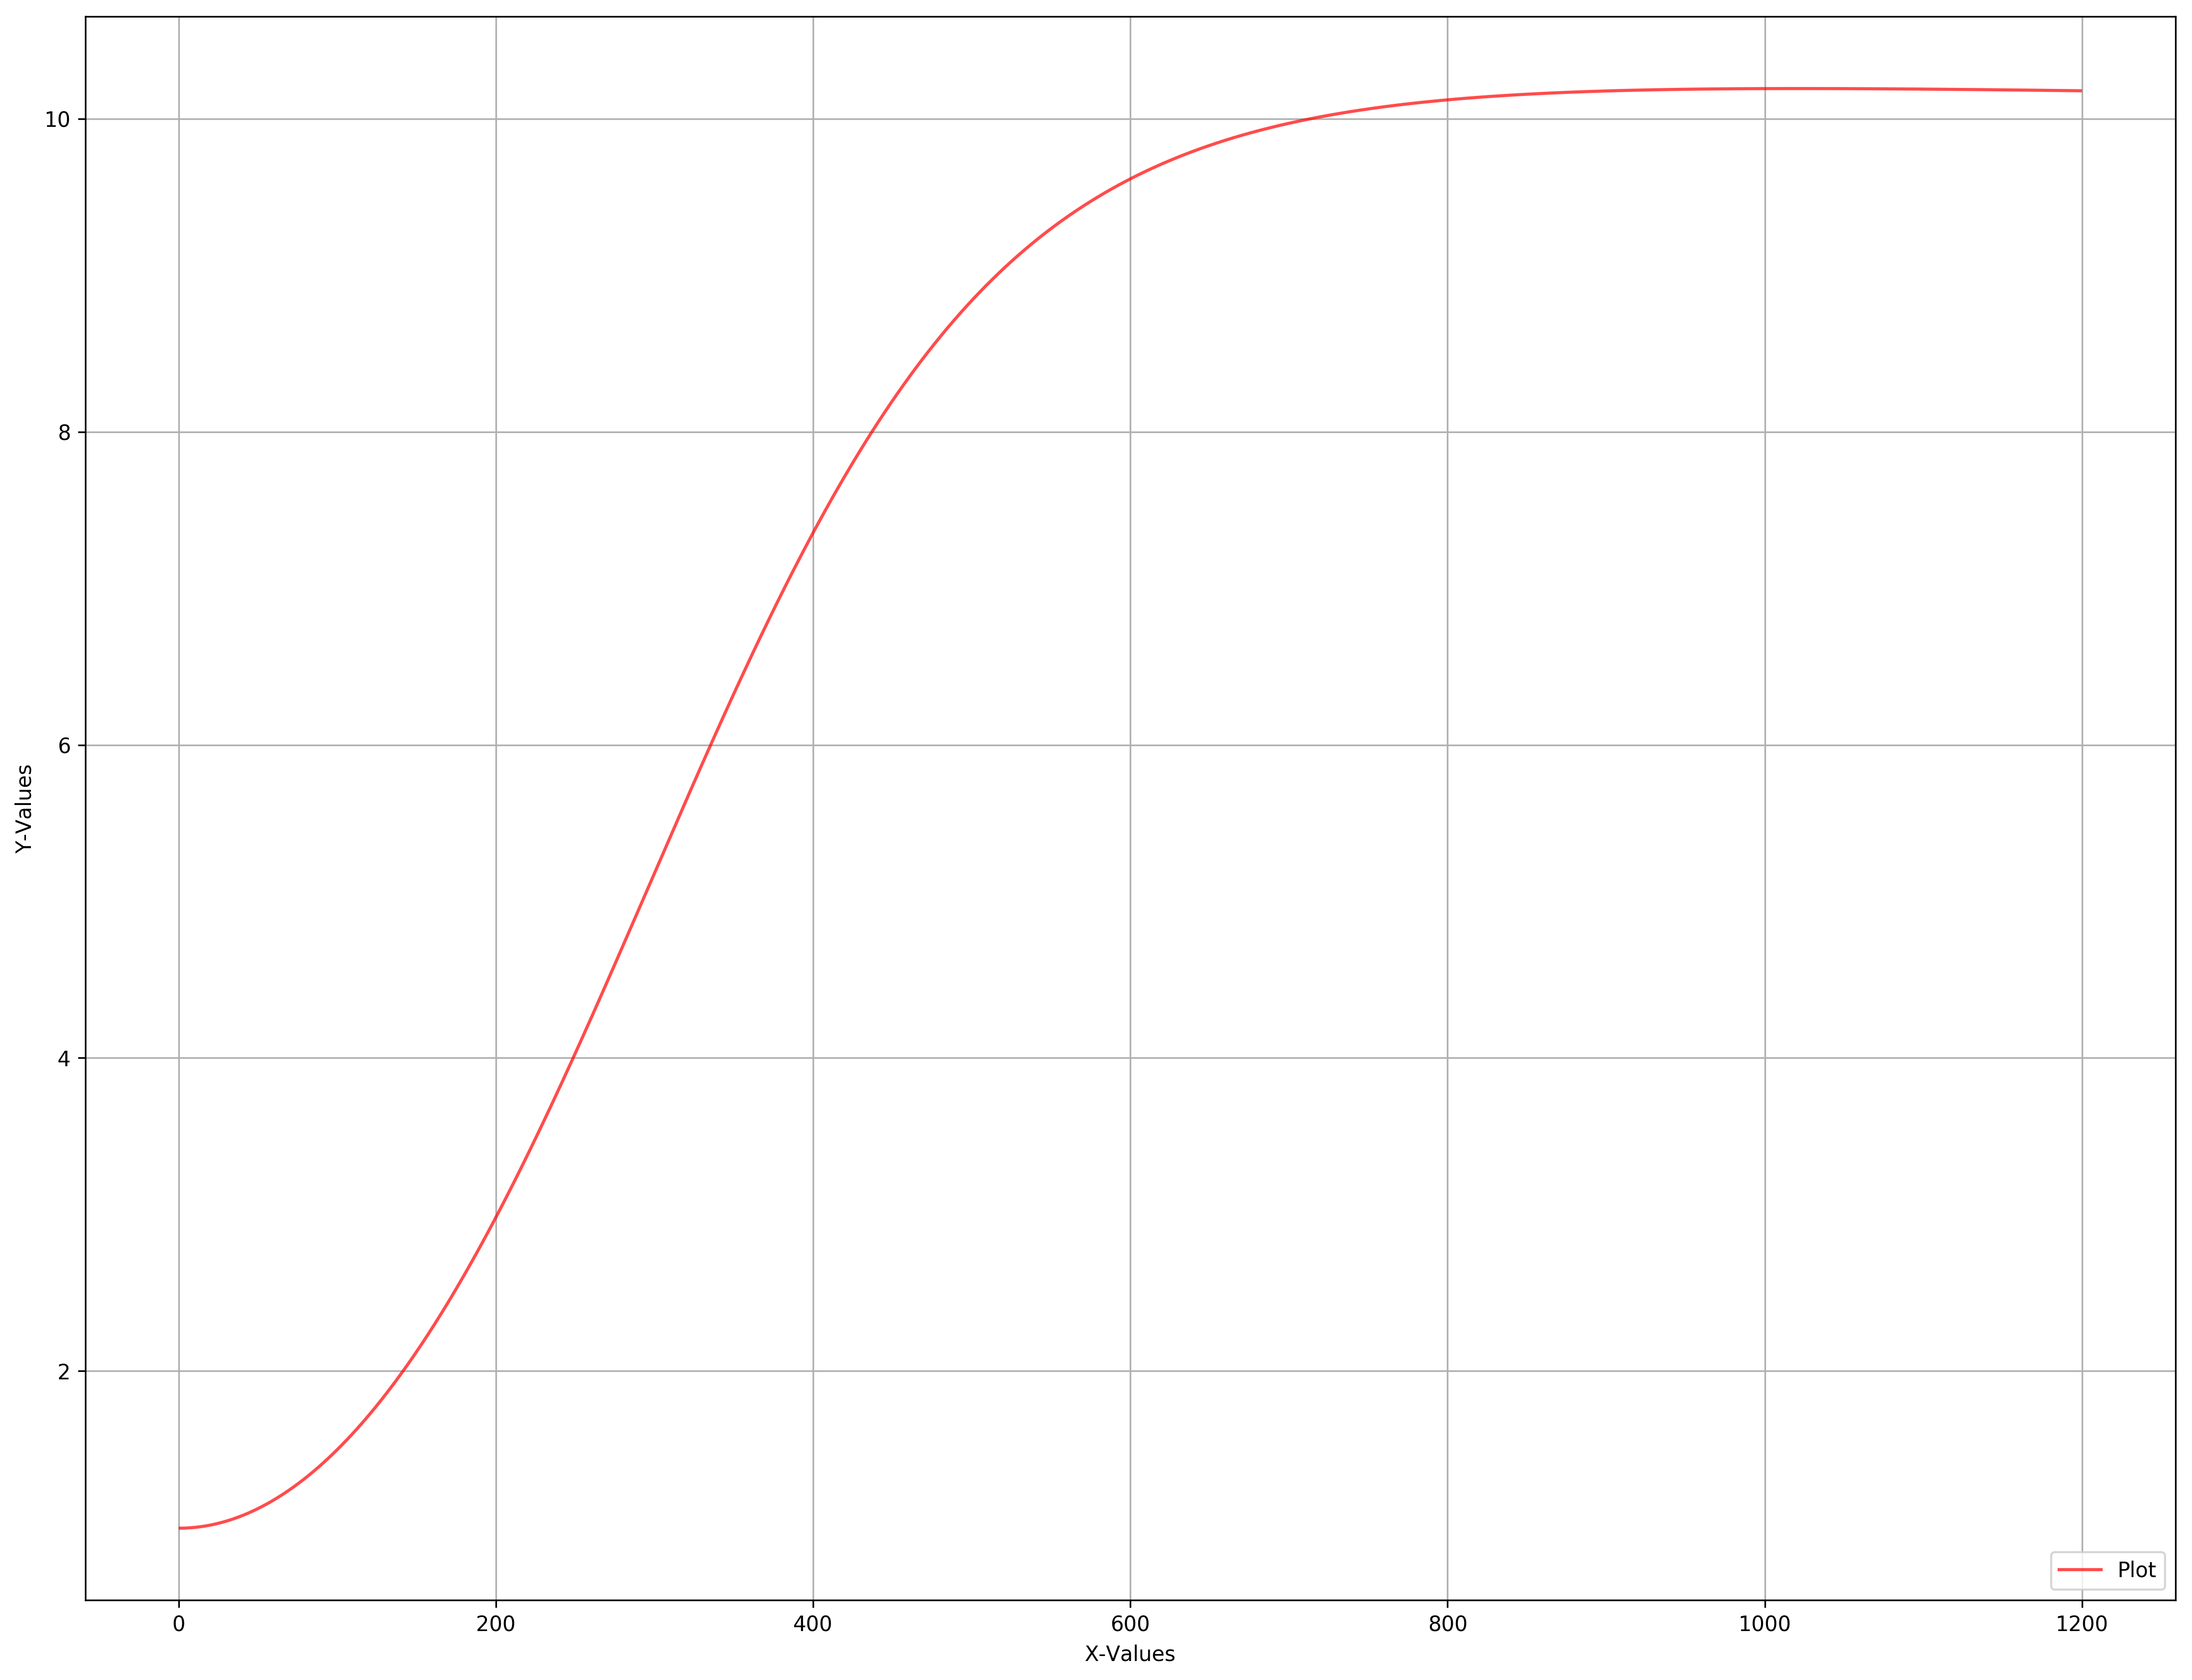

In [105]:
# def chevychase_type2_poles(h_s, h_p, w_p, n=None):
num, den = np.multiply(-0.995, [-2, 0, 1]), [0.1989, -0.6, 1]
for i, (a, b) in enumerate(zip(num, den)):
    num[i] = num[i] * (200 ** i)
    den[i] = den[i] * (200 ** i)
print (num, den)
w, h_mag, _, _, _ = magnitude_phase_response(num, den, [1, 1200], 1)
create_plot([w], [(10 ** (0.05 * h_mag), )])

In [98]:
chevychase_type2(0.2, 0.9, 0.4, 2)

(array([-3.33333333e-01+5.55111512e-17j,  7.40148683e-17-1.23259516e-32j,
         6.66666667e-01-1.11022302e-16j]),
 array([1.        +0.00000000e+00j, 1.33333333-1.66533454e-16j,
        0.66666667-1.11022302e-16j]))

In [96]:
convolve_all([[1, complex(-.468, -0.04)], [1, complex(0.145, 0.406)]])

array([ 1.     +0.j      , -0.323  +0.366j   , -0.05162-0.195808j])

In [91]:
10 ** (0.05 * -20)

0.1